In [1]:
######################################################
## Myson Burch
## Computational Genomics Team, IBM Research, NY
## Purdue University, West Lafayette, IN
## mcburch@purdue.edu
######################################################

#############################################################
##############   Packages & Helper Functions   ##############
#############################################################
import numpy as np
import pandas as pd
import random as rng
import sys, itertools, glob, warnings
import scipy 
import os, math, time, timeit, subprocess
import matplotlib as pyplot
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
sns.set(style='darkgrid')

%cd "/home/bose/Geno4SD/Geno4SD-Innersource/"
from geno4sd.statgen.masklmm import MaSkLMM

/home/bose/Geno4SD/Geno4SD-Innersource


In [2]:
def plots(df, pval_thresh, model, plots_on):

    pyplot.rcParams['figure.dpi']=600
    pyplot.rcParams.update({'font.size': 10})

    # SMALL_SIZE = 8
    # MEDIUM_SIZE = 10
    # BIGGER_SIZE = 20

    # plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    # plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    # plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    # plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    # plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    # plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

    # manhattan plot
    import pylab
    import fastlmm.util.util as flutil
    from fastlmm.util.stats import plotp

    if plots_on:
        pylab.rcParams['figure.figsize'] = (10.0, 8.0)
        if model == "mask" or model == "malmm":
            flutil.manhattan_plot(df[["Chr", "ChrPos2", "PValue"]].values,pvalue_line=pval_thresh,xaxis_unit_bp=False, alpha = 0.8)
        elif model == "fast":
            flutil.manhattan_plot(df[["Chr", "ChrPos", "PValue"]].values,pvalue_line=pval_thresh,xaxis_unit_bp=False, alpha=1.0)
        elif model == "bolt":
            flutil.manhattan_plot(df[["CHR", "BP", "PValue"]].values,pvalue_line=pval_thresh,xaxis_unit_bp=False, alpha=1.0)

        # qq plot
        plotp.qqplot(df["PValue"].values, ylim=[0,4.25])

    return plotp.estimate_lambda(df["PValue"].values)

In [3]:
def get_hits(df, pval_thresh, model, causal_fn, mode = "BN"):

    if mode == "BN":
        # checking spurious vs. causal
        causal_df = pd.read_csv(causal_fn)
        causal_df = causal_df.iloc[: , 1:]
        causal_df['x'] = 'rs000' + causal_df['x'].astype(str)

        true_hits = df.loc[df['SNP'].isin(causal_df['x'])]
        hits = df.loc[df['PValue'] < pval_thresh]
        return true_hits, hits, hits.loc[hits['SNP'].isin(causal_df['x'])]
    else:
        # checking spurious vs. causal
        causal_df = pd.read_csv(causal_fn, header = None)
        thesnps = np.reshape(causal_df.values, causal_df.values.shape[0])
        true_hits = df.loc[df['SNP'].isin(thesnps)]
        hits = df.loc[df['PValue'] < pval_thresh]
        return true_hits, hits, hits.loc[hits['SNP'].isin(thesnps)]


In [4]:
# R BN synthetic dataset (toy dataset of 5k by 5k)
bed_fn = "/data/shared/ukbb_filt_genomes/CAD/qc_final.bed"
pheno_fn = "/home/bose/CAD/CAD_pheno.txt"
cov_fn = "/data/shared/ukbb_filt_genomes/CAD/PopStrat/CAD_covars_file.txt"
#causal_fn = "sample_data/bn_causal_idx"
#mode = "BN"

In [5]:
############################################
###############   MaSk-LMM   ###############

# threshold for associations
pval_thresh = 1e-6
plots_on = 1 # 1 for "on" and 0 for "off"
LOCO = False
sample_sketch_size = 0.3
marker_sketch_size = 0.25
maxiters = 10


beg_time = time.time()
MaSkLMM_results_df, newton = MaSkLMM.run(bed_fn, 
                                         pheno_fn, 
                                         cov_fn, 
                                         sample_sketch_size = sample_sketch_size, 
                                         marker_sketch_size = marker_sketch_size, 
                                         LOCO = LOCO, 
                                         maxiters = maxiters)
print("Time to compute LMM (secs): ", str(time.time() - beg_time))


MemoryError: Unable to allocate 868. GiB for an array with shape (46566, 5004465) and data type float32

In [15]:
MaSkLMM_results_df

,SNP,Chr,ChrPos2,PValue
2118,rs0002119,10,1322915.0,3.872477e-38
3197,rs0003198,15,1972212.0,1.877939e-29
1042,rs0001043,5,687864.0,1.391292e-14
4146,rs0004147,19,2538931.0,8.665904e-11
3484,rs0003485,16,2147030.0,1.616167e-09
...,...,...,...,...
1554,rs0001555,7,986292.0,9.986813e-01
3919,rs0003920,18,2401375.0,9.987370e-01
1651,rs0001652,8,1041021.0,9.989455e-01
551,rs000552,3,402229.0,9.990333e-01


In [9]:
newton

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 6.386023031214819

In [10]:
mask_actual, mask_hits, mask_causal_hits = get_hits(MaSkLMM_results_df, 
                                                    pval_thresh, 
                                                    "mask", 
                                                    causal_fn, 
                                                    mode = mode)

In [11]:
# causal
mask_causal_hits.shape[0]

4

In [11]:
# spurious
mask_hits.shape[0] - mask_causal_hits.shape[0]

0

lambda=0.9232


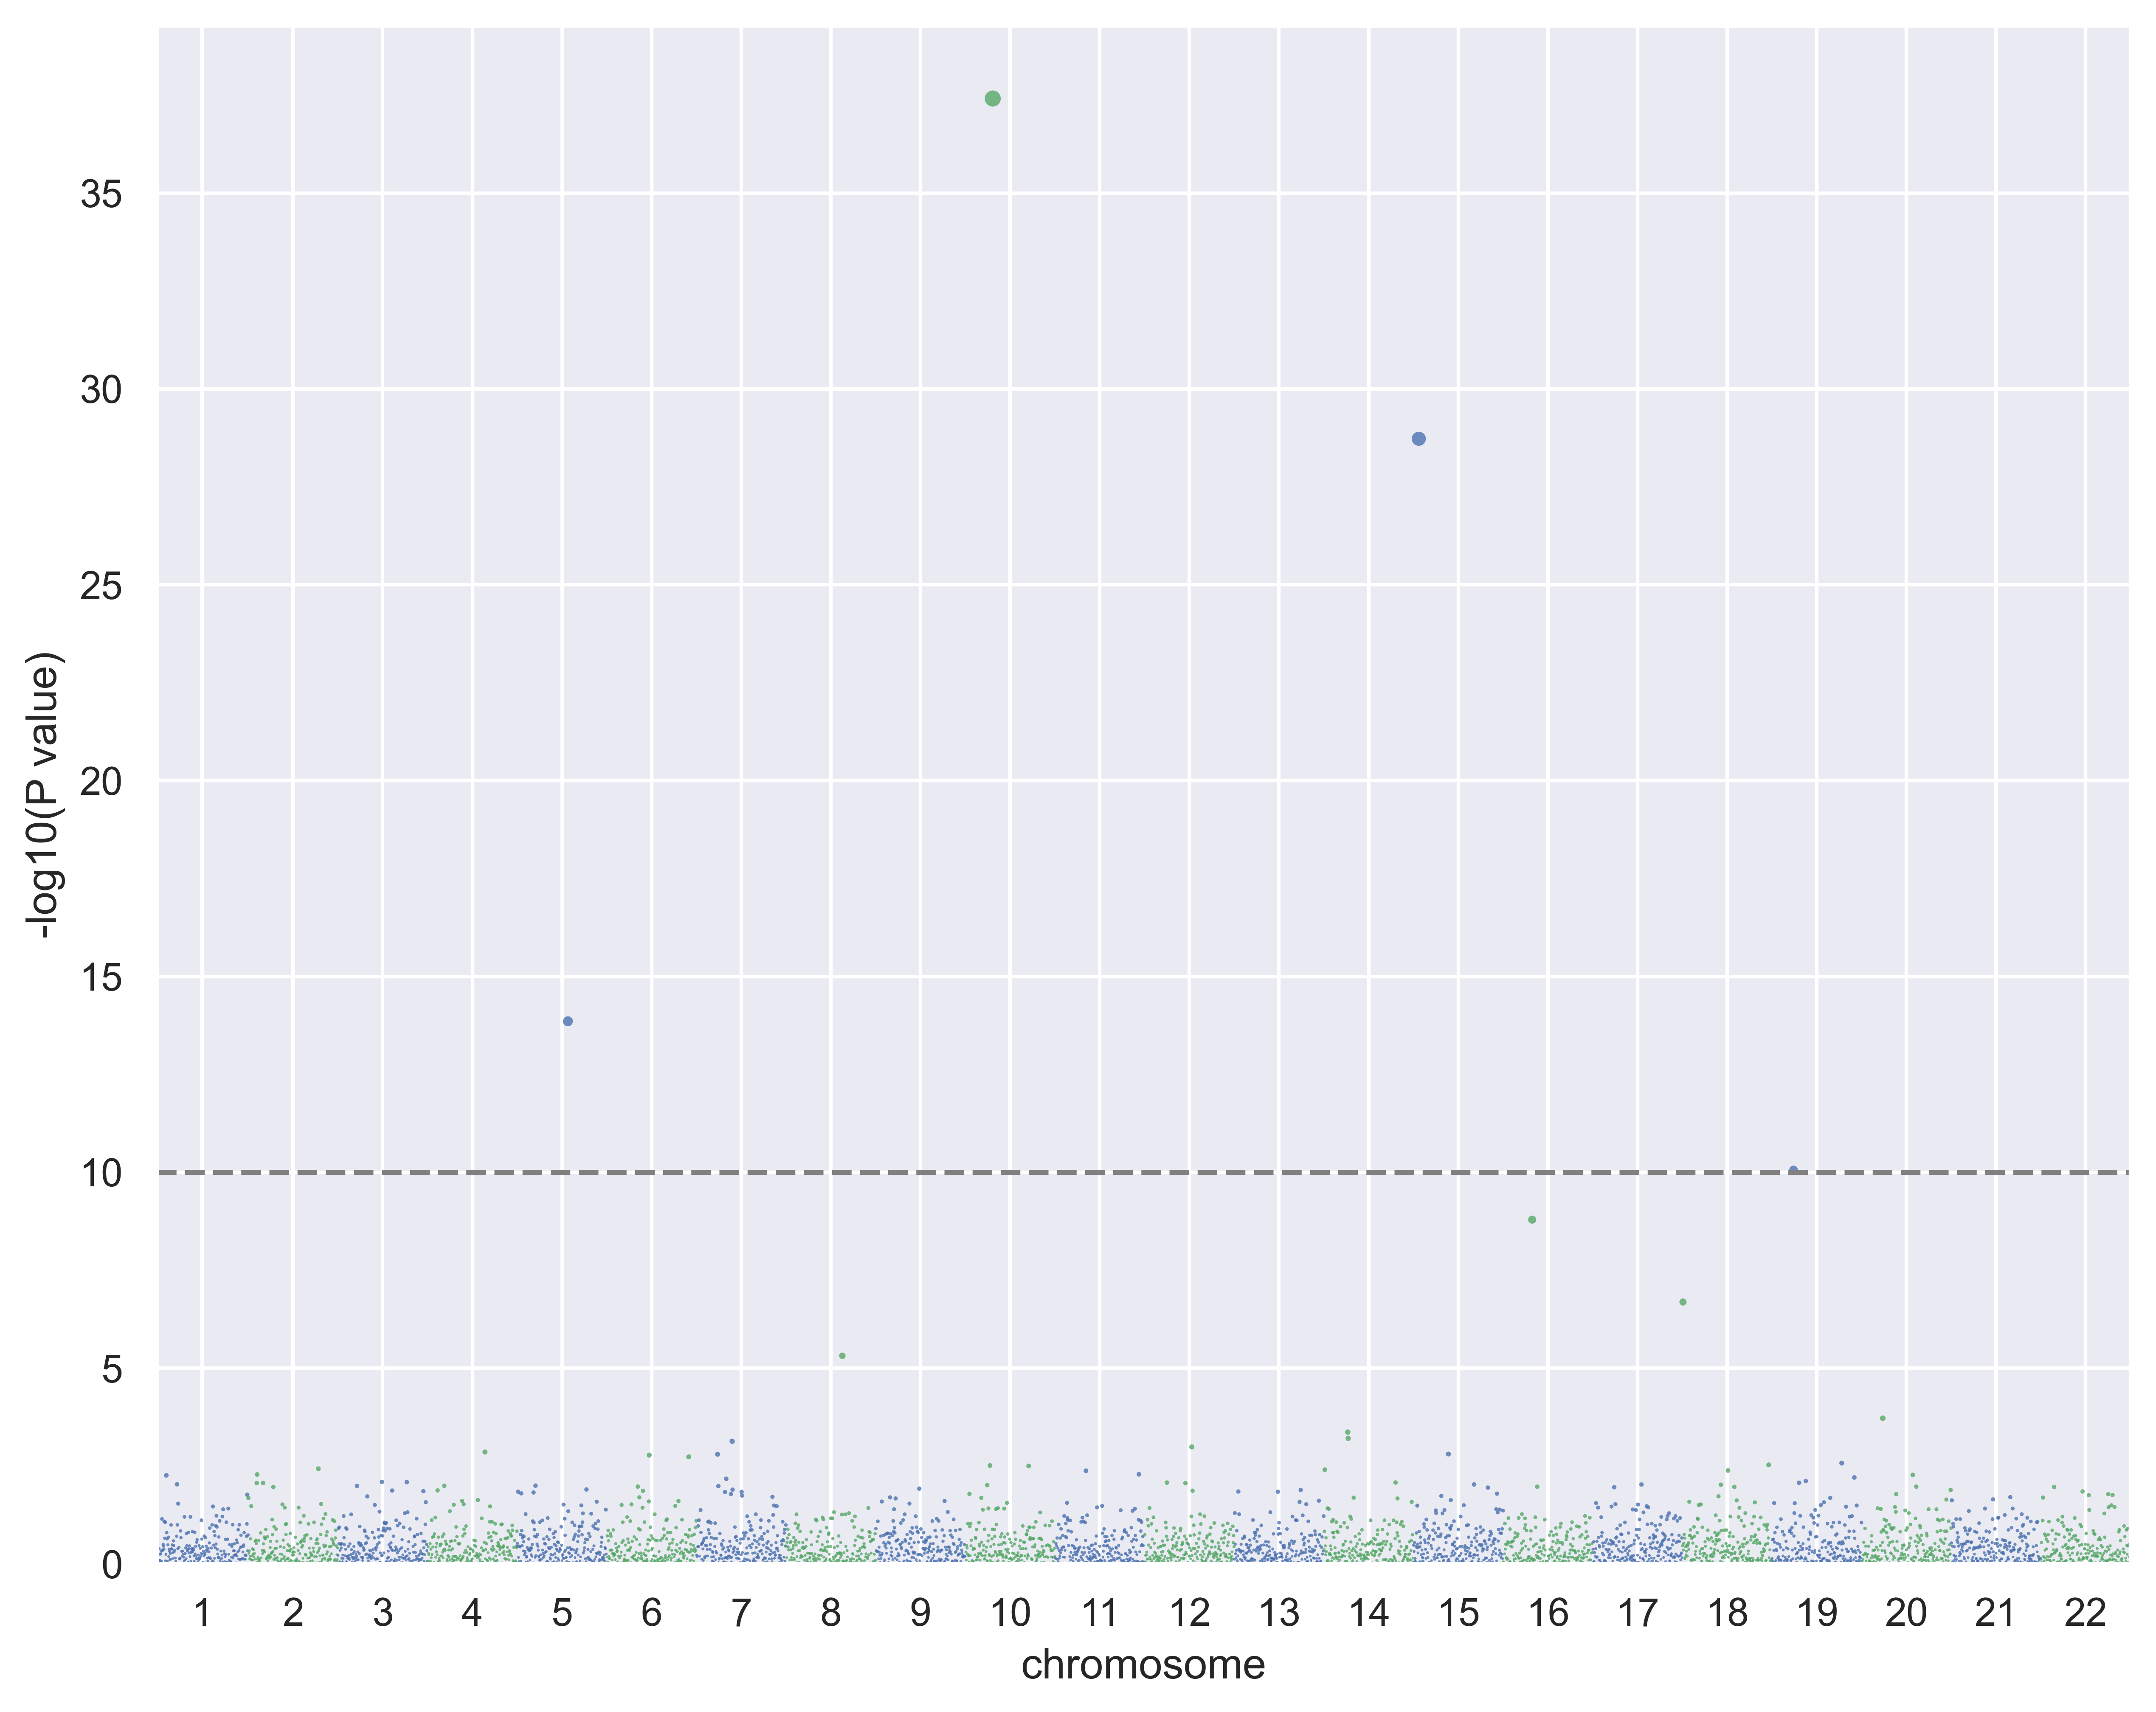

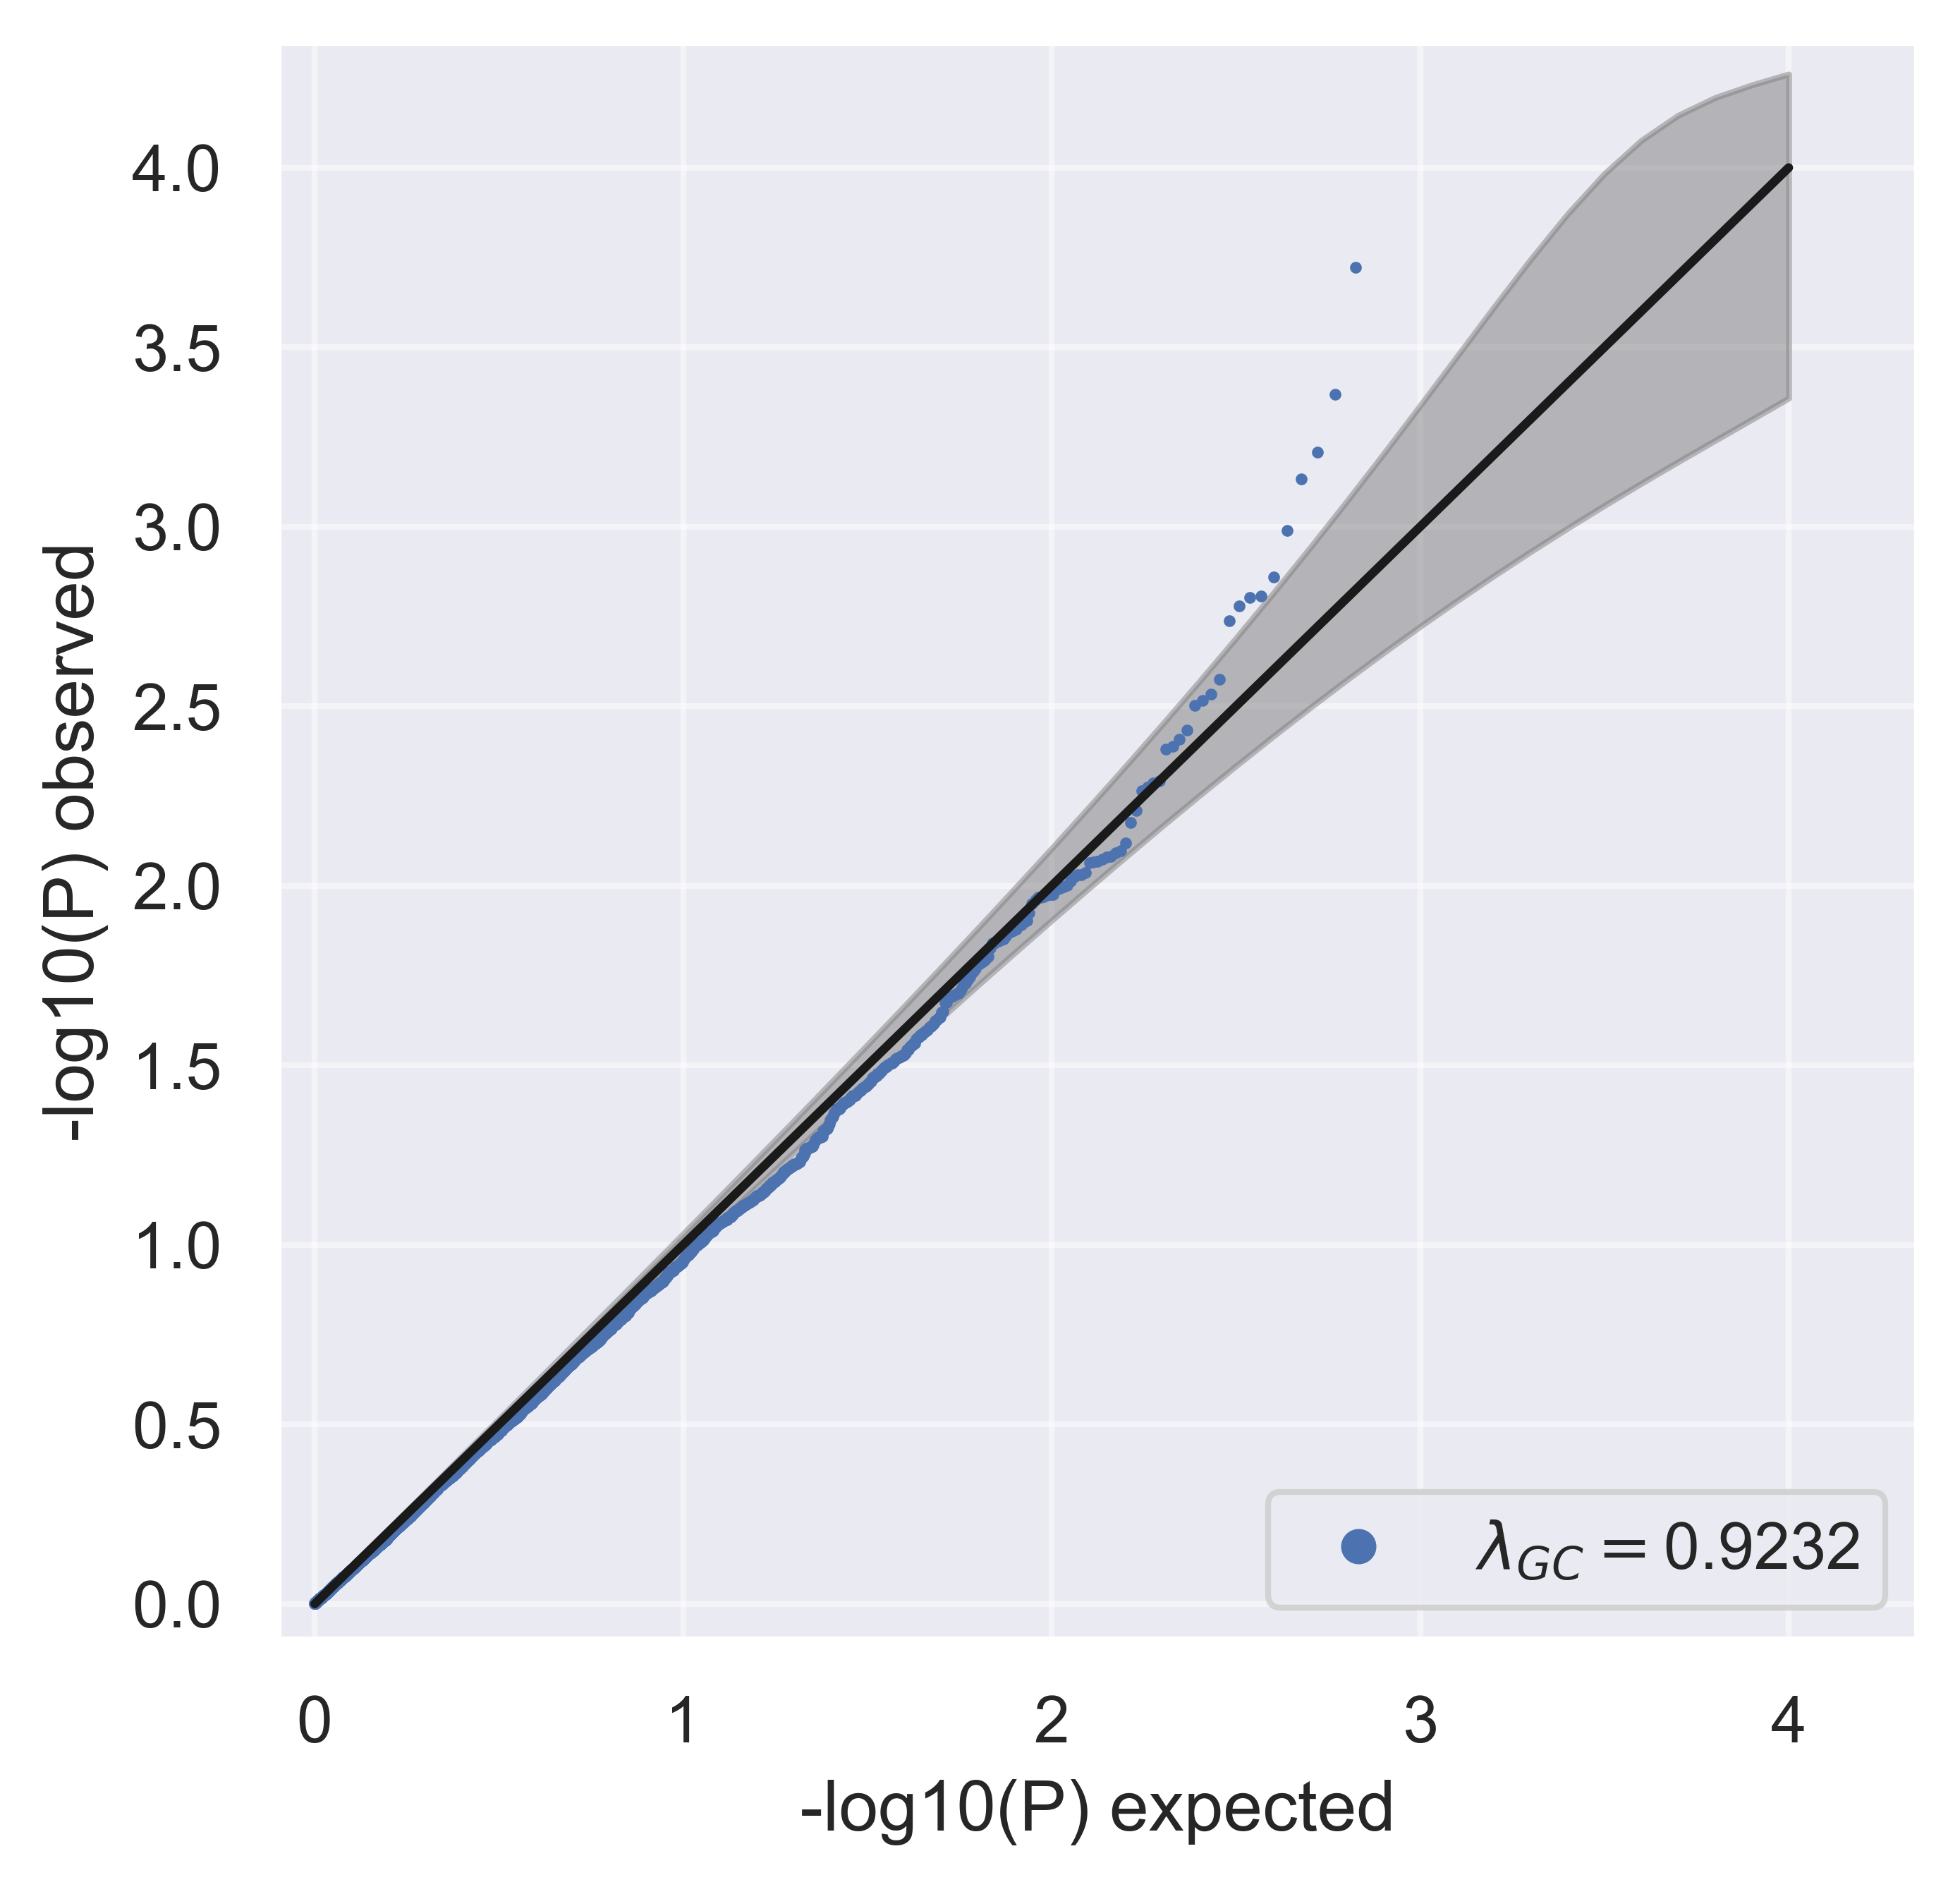

In [12]:
mask_lmbd_gc = plots(MaSkLMM_results_df, pval_thresh, "mask", plots_on)